In [2]:
%matplotlib inline

import json, glob, sys, os, gzip
from IPython.display import HTML
import ipywidgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahist import set_default_style, Hist1D, Hist2D
from tqdm.auto import tqdm

In [3]:
!cat do.sh

#!/usr/bin/env sh


# https://earlyvoting.texas-election.com/Elections/getElectionEVDates.do

for day in `seq -w 4 30`; do

    curl 'https://earlyvoting.texas-election.com/Elections/downloadVoterInfoReport.do' \
      -H 'authority: earlyvoting.texas-election.com' \
      -H 'pragma: no-cache' \
      -H 'cache-control: no-cache' \
      -H 'origin: https://earlyvoting.texas-election.com' \
      -H 'upgrade-insecure-requests: 1' \
      -H 'dnt: 1' \
      -H 'content-type: application/x-www-form-urlencoded' \
      -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36' \
      -H 'accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' \
      -H 'sec-fetch-site: same-origin' \
      -H 'sec-fetch-mode: navigate' \
      -H 'sec-fetch-user: ?1' \
      -H 'sec-fetch-dest: document' \
      -H 'referer: https://ea

In [4]:
dfs = []
for fname in tqdm(glob.glob("data_texas/*csv")):
    df = pd.read_csv(fname)
    df["date"] = pd.Timestamp(fname.rsplit("_",1)[-1].split(".",1)[0])
    dfs.append(df)
dfc = pd.concat(dfs)
del dfs

dfc.columns = dfc.columns.str.lower()
for k in ["county", "voting_method", "precinct"]:
    dfc[k] = dfc[k].astype("category")
dfc = dfc[dfc["id_voter"]!=0]
print(dfc.memory_usage(deep=True).sum()*1e-6)
dfc.drop(columns=["voter_name"])

  0%|          | 0/27 [00:00<?, ?it/s]

/var/folders/q_/4xc9d8p90fx9q_nm27yc51bh0000gn/T/ipykernel_39587/4214421782.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fname)
/var/folders/q_/4xc9d8p90fx9q_nm27yc51bh0000gn/T/ipykernel_39587/4214421782.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fname)


1030.371349


,county,id_voter,voting_method,precinct,date
0,ANDERSON,1041006052,MAIL-IN,21,2020-10-23
1,ANDERSON,1010093918,MAIL-IN,1,2020-10-23
2,ANDERSON,1041701242,MAIL-IN,13,2020-10-23
3,ANDERSON,2158189541,MAIL-IN,1,2020-10-23
4,ANDERSON,1041022736,MAIL-IN,7,2020-10-23
...,...,...,...,...,...
36176,YOAKUM,1006395235,MAIL-IN,406,2020-10-06
36177,YOAKUM,1006397250,MAIL-IN,404,2020-10-06
36178,YOUNG,1024477087,MAIL-IN,23.2,2020-10-06
36179,YOUNG,1024383367,MAIL-IN,5.2,2020-10-06


<AxesSubplot: xlabel='date'>

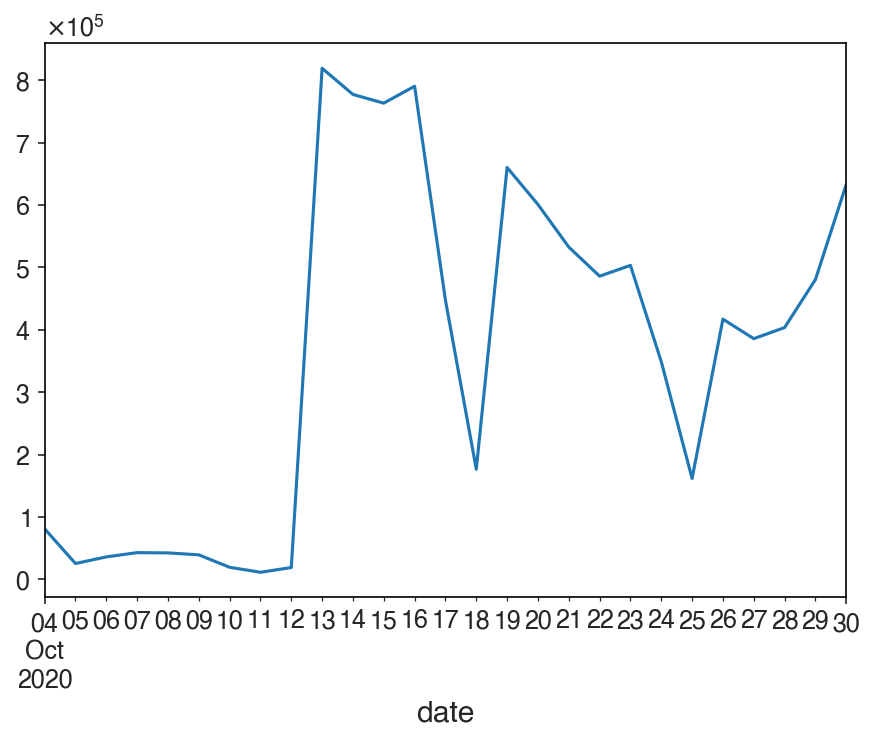

In [5]:
dfc.groupby("date").count()["county"].plot()

<AxesSubplot: >

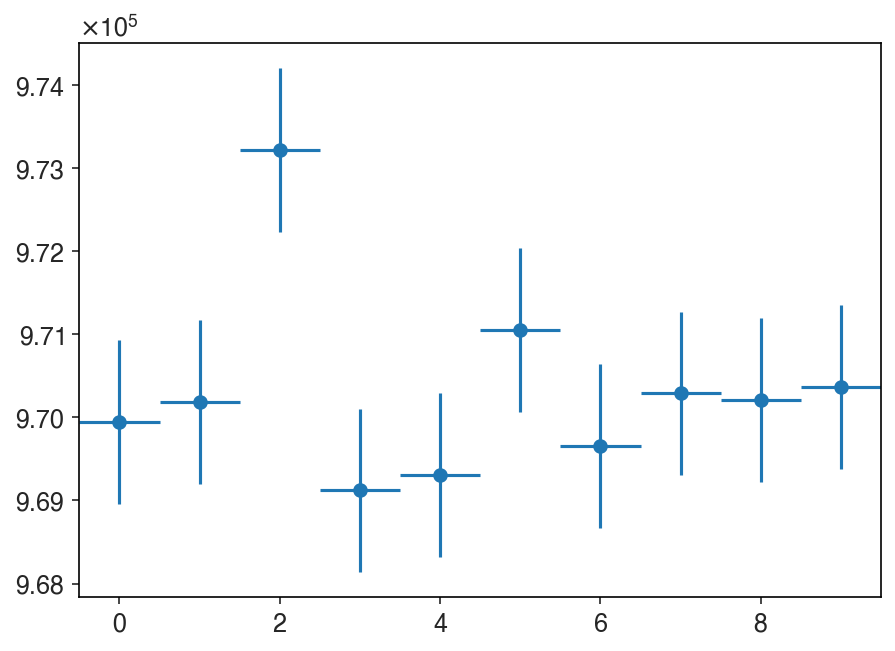

In [6]:
Hist1D((dfc["id_voter"]%100)//10).plot(show_errors=True)

In [ ]:
dfc["id_voter"].duplicated().sum()

In [ ]:
# Hist1D(dfc["id_voter"], bins="50,1.0e9,1.00001e9", overflow=False).plot()
# dfc[dfc["id_voter"].between(1.0e9,1.00001e9)].sort_values("id_voter").style

In [ ]:
df_ratio = (dfc["id_voter"]>1.5e9).groupby(dfc["county"]).agg(["mean","count"]).sort_values(["mean"])

df_fips = pd.read_csv("fips.csv")
df_fips["county"] = df_fips["county"].str.upper()
df_fips = df_fips.set_index("county")

df_ratio = df_ratio.dropna()
df_ratio["fips"] = df_fips["fips"].astype(int)

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [ ]:

import pandas as pd
df = df_ratio[["mean","fips"]]

import plotly.express as px

fig = px.choropleth(df, geojson=counties, locations='fips', color='mean',
                           color_continuous_scale="cividis",
                           range_color=(0, 0.5),
                           scope="usa",
                           labels={'mean':'mean thingy'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
s = dfc[dfc["id_voter"]>1.5e9]["id_voter"].sort_values().diff().dropna()
Hist1D(s, bins="40,0,40", overflow=False).plot(histtype="step")

In [ ]:
s = dfc[dfc["id_voter"]<1.5e9]["id_voter"].sort_values().diff().dropna()
Hist1D(s, bins="40,0,40", overflow=False).plot(histtype="step")